In [1]:
%matplotlib inline
from src.pgm import draw
from src.data import discretize, get_f1_score

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from pgmpy.models import BayesianModel

## Replacing missing values with mean

In [2]:
# df = pd.read_csv("dataset/diabetes.csv")
# df.loc[:,'Glucose':'BMI'] = df.loc[:,'Glucose':'BMI'].replace(0,np.nan)
# df = df.fillna(df.mean()).astype({
#     "Pregnancies": "int32",
#     "Glucose": "int32",
#     "BloodPressure": "int32",
#     "SkinThickness": "int32",
#     "Insulin": "int32",
#     "BMI": "int32",
#     "DiabetesPedigreeFunction": "float",
#     "Age": "int32",
#     "Outcome": "category"
# })
# kbd = KBinsDiscretizer(n_bins=5, encode='ordinal').fit(df.drop(columns="Outcome"))
# df = discretize(kbd, df)
# train, test = train_test_split(df, test_size=0.15, stratify=df["Outcome"], random_state=42)

## Get dataset fixed with based on knowledge Bayesian Model 

In [3]:
from src.data import get_fixed_dataset
df, kbd = get_fixed_dataset(return_kbd=True)
train, test = train_test_split(df, test_size=0.15, stratify=df["Outcome"], random_state=42)

100%|██████████| 140/140 [00:02<00:00, 68.33it/s]


# Model uproszczony
Rozważamy tylko zmienne:
- Glucose
- Insulin
- SkinThickness
- Outcome

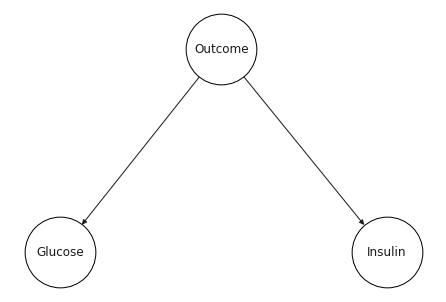

In [7]:
bn = BayesianModel([
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
])
bn.fit(train[["Glucose", "Insulin", "Outcome"]])
draw(bn)

In [8]:
y_pred = bn.predict(test[["Glucose", "Insulin"]])
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 21/21 [00:00<00:00, 6603.22it/s]F1-score: 0.77
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        72
           1       0.70      0.86      0.77        37

    accuracy                           0.83       109
   macro avg       0.81      0.84      0.82       109
weighted avg       0.84      0.83      0.83       109




# Pełen model
Wpierw badamy wyniki zwracane przez modele, których struktura wynika ze zgromadzonej wiedzy o problemie.
Wiemy, że cukrzycy 

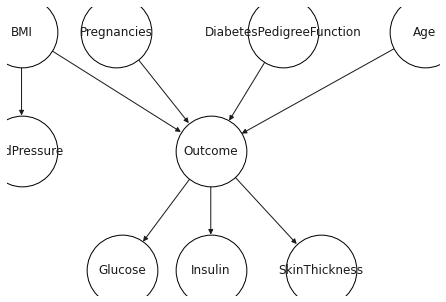

100%|██████████| 109/109 [00:01<00:00, 85.81it/s]
F1-score: 0.67
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        72
           1       0.61      0.76      0.67        37

    accuracy                           0.75       109
   macro avg       0.73      0.75      0.74       109
weighted avg       0.77      0.75      0.76       109



In [9]:
bn = BayesianModel([
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Outcome", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

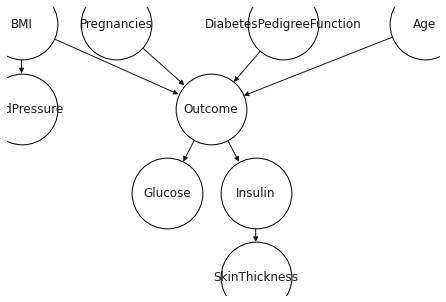

100%|██████████| 115/115 [00:01<00:00, 89.38it/s]
F1-score: 0.60
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        76
           1       0.60      0.60      0.60        40

    accuracy                           0.72       116
   macro avg       0.69      0.69      0.69       116
weighted avg       0.72      0.72      0.72       116



In [6]:
bn = BayesianModel([
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Insulin", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

# Poszukiwanie architektury grafu

  0%|          | 9/1000000 [00:00<27:52:41,  9.96it/s]


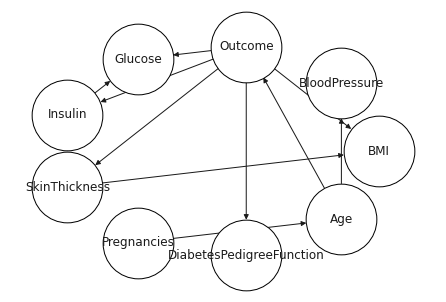

100%|██████████| 109/109 [00:00<00:00, 439.80it/s]
F1-score: 0.77
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        72
           1       0.70      0.84      0.77        37

    accuracy                           0.83       109
   macro avg       0.81      0.83      0.81       109
weighted avg       0.84      0.83      0.83       109



In [10]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score


bn_hc = HillClimbSearch(df).estimate(
    scoring_method=K2Score(df),
    start_dag=BayesianModel(list(bn.edges)),
)
draw(bn_hc, layout="kamada_kawai_layout", scale=40);
model = bn_hc.copy()
model.fit(train)
y_pred = model.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

In [11]:
bn_hc.remove_edge("Outcome", "BMI")
bn_hc.add_edge("BMI", "Outcome")

bn_hc.remove_edge("SkinThickness", "Insulin")
bn_hc.add_edge("Insulin", "SkinThickness")

bn_hc.remove_edge("Outcome", "DiabetesPedigreeFunction")
bn_hc.add_edge("DiabetesPedigreeFunction", "Outcome")

bn_hc.remove_edge("Pregnancies", "Age")

draw(bn_hc, layout="kamada_kawai_layout", scale=40);

ValueError: Loops are not allowed. Adding the edge from (BMI->Outcome) forms a loop.

In [9]:
model = bn_hc.copy()
model.fit(train)
y_pred = model.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 115/115 [00:01<00:00, 62.77it/s]
F1-score: 0.59
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        76
           1       0.57      0.60      0.59        40

    accuracy                           0.71       116
   macro avg       0.68      0.68      0.68       116
weighted avg       0.71      0.71      0.71       116



ples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Insulin ⟂ Outcome | Glucose=2.0, Age=1, SkinThickness=3.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Glucose ⟂ Outcome | Insulin=2.0, Age=3, SkinThickness=3.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Age ⟂ Outcome | Glucose=2.0, Insulin=3.0, SkinThickness=1.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test SkinThickness ⟂ Outcome | Glucose=2.0, Insulin=3.0, Age=0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test SkinThickness ⟂ Outcome | 

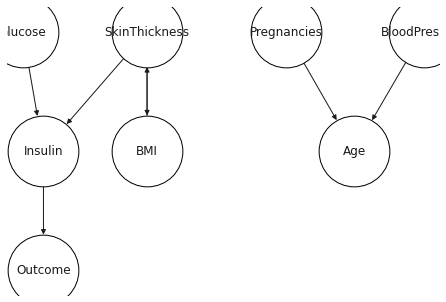

In [27]:
from pgmpy.estimators import PC
pc_est = PC(data=df)
skeleton_pc, separating_sets_pc = pc_est.build_skeleton(variant='parallel')
pdag = pc_est.skeleton_to_pdag(skeleton_pc, separating_sets_pc)
draw(pdag)

In [23]:
bn_pc = BayesianModel(list(skeleton_pc.edges))
bn_pc.add_nodes_from(bn)
bn_pc.fit(train)
y_pred = bn_pc.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 109/109 [00:02<00:00, 49.64it/s]
F1-score: 0.79
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        72
           1       0.77      0.81      0.79        37

    accuracy                           0.85       109
   macro avg       0.83      0.84      0.84       109
weighted avg       0.86      0.85      0.85       109



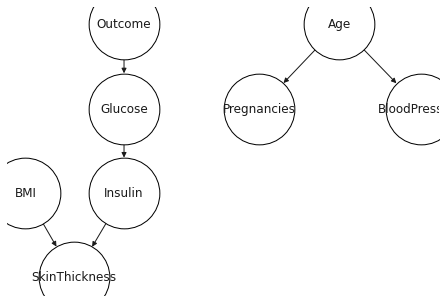

In [28]:
pdag.remove_edge("Pregnancies", "Age")
pdag.add_edge("Age", "Pregnancies")

pdag.remove_edge("BloodPressure", "Age")
pdag.add_edge("Age", "BloodPressure")

pdag.remove_edge("SkinThickness", "Insulin")
pdag.add_edge("Insulin", "SkinThickness")

pdag.remove_edge("Insulin", "Outcome")
pdag.add_edge("Outcome", "Glucose")

#pdag.add_edge("Pregnancies", "Outcome")

pdag.remove_edge("SkinThickness", "BMI")

draw(pdag)

In [29]:
bn_pc = BayesianModel(list(pdag.edges))
bn_pc.add_nodes_from(bn)
bn_pc.fit(train)
y_pred = bn_pc.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 109/109 [00:00<00:00, 554.35it/s]
F1-score: 0.41
              precision    recall  f1-score   support

           0       0.71      0.86      0.78        72
           1       0.55      0.32      0.41        37

    accuracy                           0.68       109
   macro avg       0.63      0.59      0.59       109
weighted avg       0.66      0.68      0.65       109

